# Valeurs de Shapley et SHAP

## Les valeurs de Shapley

Les valeurs de Shapley puisent leurs origines dans la théorie des jeux coopératifs. Ces valeurs furent calculées par Lloyd Shapley en 1953. Les valeurs de Shapley indiquent la répartition équitable des gains parmi les joueurs (ou *acteurs*) d'une coalition dans le cadre d'un jeu coopératif. Cette configuration induit une **utilité transférable**, puisque l'objectif de cette coalition est de **maximiser** le profit global, pour ensuite redistribuer ce montant parmi les membres de la coalition. Il est important de distinguer la notion d'équité et d'égalité. Soient trois joueurs $A, B$ et $C$ qui, individuellement, n'apportent aucun gain, mais qui, sous forme de coalition, apportent les gains suivants :

- la coalition $\{A, B\}$ rapporte $2$ ;
- la coalition $\{A, C\}$ rapporte $2$ ;
- la coalition $\{B, C\}$ rapporte $3$ ;
- la coalition totale $\{A, B, C\}$ rapporte le gain total $4$.

Dans cet exemple, il est clair que la coalition $\{B, C\}$ est celle qui **contribue** le plus au gain total par rapport aux autres coalitions. Ainsi, pour satisfaire une notion d'équité, les joueurs de la coalition $\{B, C\}$ doivent recevoir une part plus importante du gain total par rapport au joueur $A$.

Pour un jeu coopératif à $p$ joueurs, il peut y avoir $2^p-1$ coalitions non vides possibles, où chaque joueur est identifié par un indice allant de $1$ à $p$. Le profit **est supposé connu** pour chaque partie de $\{1,…,p\}$, et se quantifie par la \textbf{fonction caractéristique} $v:\mathcal{P}(\{1,…,p\}) \rightarrow \mathbb{R}$, et vérifiant $v(\emptyset)=0$. En pratique, rien ne suppose que les gains d'une coalition soient toujours supérieurs à la somme des gains de chaque joueur, soit

$$v \left( \bigcup_i \{i\} \right) \ngeqslant \sum_{i} v(\{i\}).
\label{eq:shapley_coalition}$$

Dans ce cas de figure, un ou plusieurs joueurs auront une valeur de Shapley **inférieure** au gain individuel, car ils contribueront à faire baisser les gains lors du rassemblement en coalition. Cet événement peut survenir dans des cadres classiques de la théorie moderne de l'économie (deux entreprises qui coopèrent ensemble peuvent obtenir un profit moins élevé que si elles ne coopéraient pas), mais cet aspect est particulièrement important en apprentissage supervisé, ce qui sera détaillé par la suite.

Shapley a donc déterminé la seule solution qui vérifie ces axiomes, à savoir

$$\phi_i=\sum_{Z \subseteq\{1, \dots, p\} : j \in Z} \frac{(p-|Z|)!(|Z|-1)!}{p!}\left [ v(Z)-v(Z \backslash \{ j\}) \right ]$$

où $|Z|$ désigne la cardinalité de l'ensemble $Z$. Cette formule opère comme définition des valeurs de Shapley que nous utiliserons dans la modélisation. Notons que le calcul des valeurs de Shapley implique de **connaître les gains pour toutes les coalitions possibles**. Dans certains domaines (économique par exemple), cela n'est pas toujours possible, notamment lorsque les coalitions ne peuvent pas se reformer (si deux entreprises coopèrent, leurs gains individuels après coopération peuvent être différents des gains individuels avant coopération). Ainsi, $v$ est **entièrement déterminée** et pour tout $C \subseteq \{1, \dots, p\}$, la valeur $v(C)$ est connue.

In [2]:
import numpy as np
import pandas as pd
from warnings import filterwarnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

filterwarnings('ignore')

data = pd.read_csv("haythem.csv")
clean_column_name = []
columns = data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
data.columns = clean_column_name
data = data.drop(["rownumber", "customerid", "surname"], axis=1)

cleaned_data = data.copy()
cleaned_data = cleaned_data[~((cleaned_data['exited'] == 1) & (cleaned_data['numofproducts'] == 4))]
cleaned_data.shape
cleaned_data


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
X = cleaned_data.iloc[:, :-1].copy()
y = cleaned_data['exited']
X['gender'] = X['gender'].apply(lambda x: 1 if x == "Female" else 0)
X = X.join(pd.get_dummies(data['geography']))
del X['geography']
clean_column_name = []
columns = X.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
X.columns = clean_column_name

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,france,germany,spain
3219,505,1,37,10,122453.97,2,1,1,52693.99,0,1,0
3128,832,1,34,6,138190.13,2,0,1,146511.20,0,0,1
2278,473,1,33,5,125827.43,1,0,1,145698.73,1,0,0
3896,741,1,21,9,0.00,2,0,1,139259.54,1,0,0
489,714,1,55,9,180075.22,1,1,1,100127.71,0,1,0


In [5]:
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.1,
    max_detph=10
)
xgb.fit(X_train, y_train)
f1_score(y_test, xgb.predict(X_test))

[16:26:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_detph } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.5746691871455576

## Application de SHAP

In [6]:
!pip install shap

In [7]:
import shap
from sklearn.utils.random import sample_without_replacement

explainer = shap.TreeExplainer(xgb)
X_shap = X.iloc[sample_without_replacement(X.shape[0], int(X.shape[0] * 0.1)), :]
shap_values = explainer.shap_values(X_shap)

shap.initjs()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 341: invalid start byte

### Étude individuelle

In [5]:
index = 806
index = 313
shap.force_plot(explainer.expected_value, shap_values[index,:], X_shap.iloc[index,:])

NameError: name 'explainer' is not defined

In [13]:
shap.force_plot(explainer.expected_value, shap_values, X_shap)

### Étude globale

Cette fois-ci, on récupère tous les individus.

In [9]:
X_shap = X.iloc[sample_without_replacement(X.shape[0], int(X.shape[0] * 1)), :]
shap_values = explainer.shap_values(X_shap)

NameError: name 'explainer' is not defined

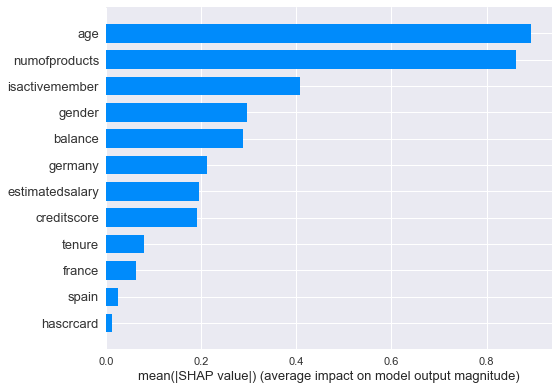

In [16]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

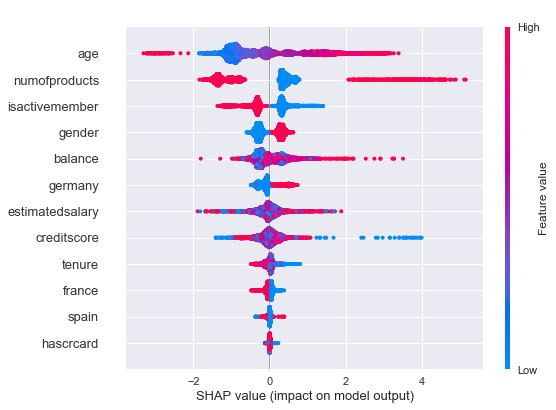

In [17]:
shap.summary_plot(shap_values, X_shap)

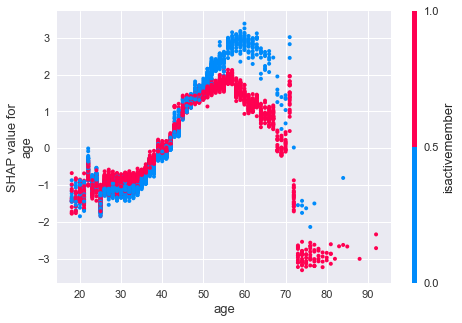

In [18]:
shap.dependence_plot("age", shap_values, X_shap)

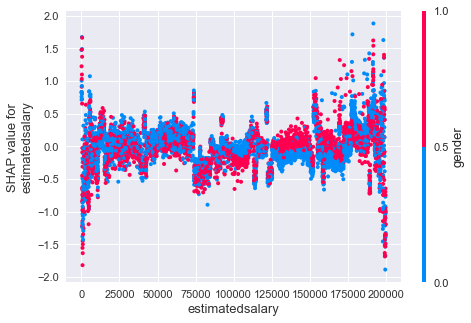

In [19]:
shap.dependence_plot("estimatedsalary", shap_values, X_shap)

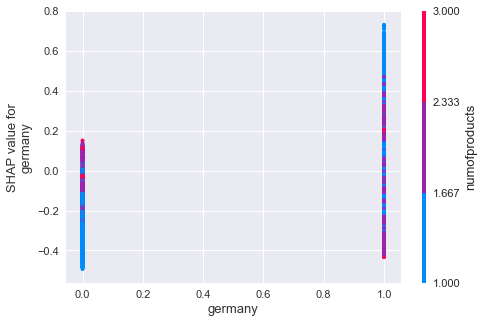

In [20]:
shap.dependence_plot("germany", shap_values, X_shap)

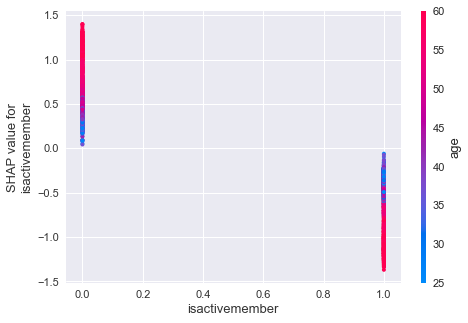

In [21]:
shap.dependence_plot("isactivemember", shap_values, X_shap)